In [6]:
import cv2
import os
from matplotlib import pyplot as plt
import random
import pdb
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle
import hashlib
# !{sys.executable} -m pip install sklearn
from sklearn.linear_model import LogisticRegression

 Helpful sources: http://mlwak.blogspot.com/2016/06/udacity-assignment-1-not-mnist.html

### 1: load data and show some images

In [7]:
def plot_samples(folders, sample_size, name):
    figure = plt.figure()
    figure.suptitle(name)
    for folder in folders:
        image_names = os.listdir(folder)
        image_names_samples = random.sample(image_names, sample_size)
        for image_name in image_names_samples:
            subplot = figure.add_subplot(
                sample_size,
                len(folders),
                list(folders).index(folder) * sample_size + image_names_samples.index(image_name) + 1
            )
            image = cv2.imread(os.path.join(folder, image_name))
            subplot.imshow(image)
            subplot.set_axis_off()
    plt.show()

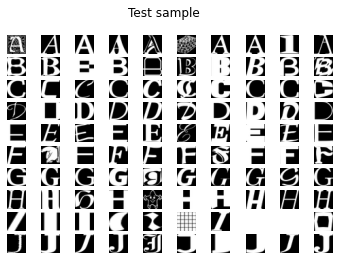

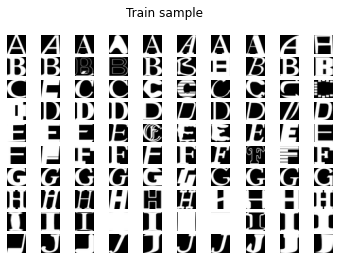

In [8]:
train_sample_folder = './data/notMNIST_large'
test_sample_folder = './data/notMNIST_small'
train_sample_folders = np.sort([os.path.join(train_sample_folder, folder) for folder in os.listdir(train_sample_folder) if not folder.endswith('.pickle')])
test_sample_folders = np.sort([os.path.join(test_sample_folder, folder) for folder in os.listdir(test_sample_folder) if not folder.endswith('.pickle')])

plot_samples(train_sample_folders, 10, 'Test sample')
plot_samples(test_sample_folders, 10, 'Train sample')

In [9]:
image_size = 28 # Pixel width and height.
pixel_depth = 255.0 # Number of levels per pixel.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

In [10]:
def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    """image_files is an array of all the filenames"""
    image_files = os.listdir(folder)
    """dataset is an array of length being the total number of images, and each image is 28x28"""
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            """this is the normalization step - the formula is [value-(255/2)]/255"""
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            """after the normalization, stick the normalized image into the dataset array at the nth position"""
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

In [11]:
# Pickle is used for serializing and de-serializing Python object structures,
# also called marshalling or flattening.
def pickle_dataset(data_folders, min_num_images_per_class):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename):
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names


In [12]:
train_datasets = pickle_dataset(train_sample_folders, 45000)
test_datasets = pickle_dataset(test_sample_folders, 1800)

./data/notMNIST_large/A.pickle already present - Skipping pickling.
./data/notMNIST_large/B.pickle already present - Skipping pickling.
./data/notMNIST_large/C.pickle already present - Skipping pickling.
./data/notMNIST_large/D.pickle already present - Skipping pickling.
./data/notMNIST_large/E.pickle already present - Skipping pickling.
./data/notMNIST_large/F.pickle already present - Skipping pickling.
./data/notMNIST_large/G.pickle already present - Skipping pickling.
./data/notMNIST_large/H.pickle already present - Skipping pickling.
./data/notMNIST_large/I.pickle already present - Skipping pickling.
./data/notMNIST_large/J.pickle already present - Skipping pickling.
./data/notMNIST_small/A.pickle already present - Skipping pickling.
./data/notMNIST_small/B.pickle already present - Skipping pickling.
./data/notMNIST_small/C.pickle already present - Skipping pickling.
./data/notMNIST_small/D.pickle already present - Skipping pickling.
./data/notMNIST_small/E.pickle already present -

2: check if samples are balanced

In [13]:
# returns array of images count in each folder
def num_of_images(datasets):
    num = []

    for pickle_file in datasets:
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            print('Total images in', pickle_file, ':', len(data))
            num.append(len(data))

    return num

In [14]:
def balance_check(sizes):
    mean_val = mean(sizes)
    print('mean of # images :', mean_val)
    for i in sizes:
        if abs(i - mean_val) > 0.1 * mean_val:
            print("Too much or less images")
        else:
            print("Well balanced", i)

In [15]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [16]:
# generates array of indexes of letters
def generate_fake_label(sizes):
    labels = np.ndarray(sum(sizes), dtype=np.int32)
    start = 0
    end = 0
    for label, size in enumerate(sizes):
        start = end
        end += size
        for j in range(start, end):
            labels[j] = label
    return labels

In [17]:
def plot_balance(train_labels, test_labels):
    fig, ax = plt.subplots(1, 2)
    bins = np.arange(train_labels.min(), train_labels.max() + 2)
    ax[0].hist(train_labels, bins=bins)
    ax[0].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[0].set_title("Training data")

    bins = np.arange(test_labels.min(), test_labels.max() + 2)
    ax[1].hist(test_labels, bins=bins)
    ax[1].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[1].set_title("Test data")
    plt.show()

Total images in ./data/notMNIST_small/A.pickle : 1872
Total images in ./data/notMNIST_small/B.pickle : 1873
Total images in ./data/notMNIST_small/C.pickle : 1873
Total images in ./data/notMNIST_small/D.pickle : 1873
Total images in ./data/notMNIST_small/E.pickle : 1873
Total images in ./data/notMNIST_small/F.pickle : 1872
Total images in ./data/notMNIST_small/G.pickle : 1872
Total images in ./data/notMNIST_small/H.pickle : 1872
Total images in ./data/notMNIST_small/I.pickle : 1872
Total images in ./data/notMNIST_small/J.pickle : 1872
Total images in ./data/notMNIST_large/A.pickle : 52909
Total images in ./data/notMNIST_large/B.pickle : 52911
Total images in ./data/notMNIST_large/C.pickle : 52912
Total images in ./data/notMNIST_large/D.pickle : 52911
Total images in ./data/notMNIST_large/E.pickle : 52912
Total images in ./data/notMNIST_large/F.pickle : 52912
Total images in ./data/notMNIST_large/G.pickle : 52912
Total images in ./data/notMNIST_large/H.pickle : 52912
Total images in ./da

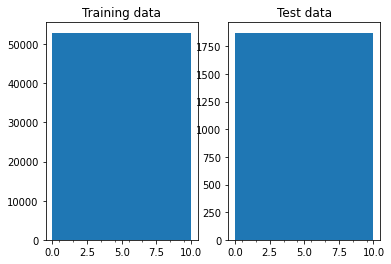

In [18]:
test_labels = generate_fake_label(num_of_images(test_datasets))
train_labels = generate_fake_label(num_of_images(train_datasets))

# Checking balance
balance_check(num_of_images(test_datasets))
balance_check(num_of_images(train_datasets))

plot_balance(train_labels=train_labels, test_labels=test_labels)


In [19]:
# 3: divide into train (200k images), valid (10k images), test (19k images) subsamples

In [20]:
# creates 2 blank arrays for each class - 1 3D array for the data, and 1 array for the labels
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


In [21]:
# merge samples from each class into 1 dataset
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels


In [22]:
train_size = 200000
valid_size = 19000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (19000, 28, 28) (19000,)
Testing: (10000, 28, 28) (10000,)


In [23]:
# 4: check if data from train sample doesn't cross other samples


In [24]:
pickle_file = './data/notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [25]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 719060515


In [26]:
def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [27]:
overlap_test_train = extract_overlap_hash_where(test_dataset, train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))

Number of overlaps: 1309


In [28]:
def sanitize(dataset_1, dataset_2, labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []  # list of indexes
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)


In [29]:
test_dataset_sanit, test_labels_sanit = sanitize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))
valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)


Overlapping images removed from test_dataset:  1309
Overlapping images removed from valid_dataset:  2070
Training: (200000, 28, 28) (200000,)
Validation: (16930,) (16930,)
Testing: (8691, 28, 28) (8691,)


In [30]:
def randomize(dataset, labels):
    #     permutes the order of the dataset and corresponding labels
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [31]:
pickle_file_sanit = './data/notMNIST_sanit.pickle'

try:
    f = open(pickle_file_sanit, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 708450455


In [32]:
#5: Create logistic regression classifier
# Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000)


In [33]:
def disp_sample_dataset(dataset, labels, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset[item])
    plt.show()

In [34]:
def train_and_predict(sample_size):
    regr = LogisticRegression()

    # convert 3d array to 2d
    X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
    y_train = train_labels[:sample_size]
    regr.fit(X_train, y_train)

    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels

    pred_labels = regr.predict(X_test)
    
    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)
    disp_sample_dataset(test_dataset, pred_labels, 'sample_size=' + str(sample_size))


/home/ermolkin/study/mo/prev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Accuracy: 0.6074 when sample_size= 50


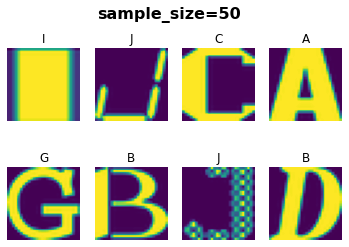

/home/ermolkin/study/mo/prev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Accuracy: 0.731 when sample_size= 100


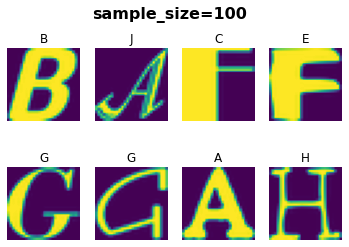

/home/ermolkin/study/mo/prev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Accuracy: 0.8317 when sample_size= 1000


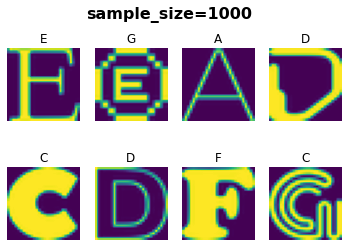

/home/ermolkin/study/mo/prev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Accuracy: 0.845 when sample_size= 5000


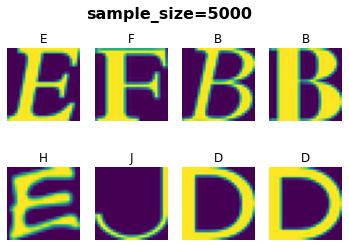

/home/ermolkin/study/mo/prev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Accuracy: 0.8978 when sample_size= 200000


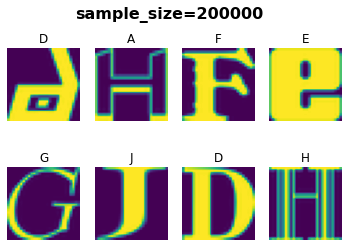

In [35]:
for sample_size in [50, 100, 1000, 5000, len(train_dataset)]:
    train_and_predict(sample_size)
